In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [3]:
url = "updated_train.csv"

df = pd.read_csv(url)

df.head()

list(df)

['Id',
 'Monthly rent payment',
 '=1 Overcrowding by bedrooms',
 ' number of all rooms in the house',
 '=1 Overcrowding by rooms',
 '=1 has toilet in the household',
 '=1 if the household has refrigerator',
 'owns a tablet',
 'number of tablets household owns',
 'Males younger than 12 years of age',
 'Males 12 years of age and older',
 'Total males in the household',
 'Females younger than 12 years of age',
 'Females 12 years of age and older',
 'Total females in the household',
 'persons younger than 12 years of age',
 'persons 12 years of age and older',
 'Total persons in the household',
 'size of the household',
 'TamViv',
 'years of schooling',
 'Years behind in school',
 'household size',
 '=1 if predominant material on the outside wall is block or brick',
 '=1 if predominant material on the outside wall is socket (wood, zinc or absbesto',
 '=1 if predominant material on the outside wall is prefabricated or cement',
 '=1 if predominant material on the outside wall is waste materi

1) (yes) Replace all yes with 1 and no with 0 (yes)

2) (yes)- Only use rows with parentesco == 1 

3) (yes) Drop squared variables

4) (yes) Check NA:
    - Monthly rate payment: replace it with 0
    - years behind schooling: replace it with 0 (not behind in school/ too young)
    - number of tablets household owns: NA own no ipad
    
5) (yes) Round floats to 2 decimal numbers after comma

In [4]:
#Adjust some column names
df.rename(columns = {"=1 region PacÃƒÂ\xadfico central" : "=1 region Pacifico central", "=1 region Huetar AtlÃƒÂ¡ntica" : "=1 region Huetar Atlantica", "=1 if free or coupled uunion": "=1 if free or coupled union", " number of all rooms in the house": 'number of all rooms in the house', "TamViv": "number of persons living in the household"}, inplace = True)

df.head()

df.shape

(9557, 143)

In [5]:
#replace yes and no with 1 and 0
df.select_dtypes('object').head()

mapping = {"yes": 1, "no": 0}

for i in [df]:
    # Fill in the values with the correct mapping
    i['Dependency rate'] = i['Dependency rate'].replace(mapping).astype(np.float64)
    i['years of education of female head of household'] = i['years of education of female head of household'].replace(mapping).astype(np.float64)
    i['years of education of male head of household'] = i['years of education of male head of household'].replace(mapping).astype(np.float64)

df[['Dependency rate', 'years of education of female head of household', 'years of education of male head of household']].describe()

,Dependency rate,years of education of female head of household,years of education of male head of household
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


Target
4    5996
2    1597
3    1209
1     755
Name: count, dtype: int64

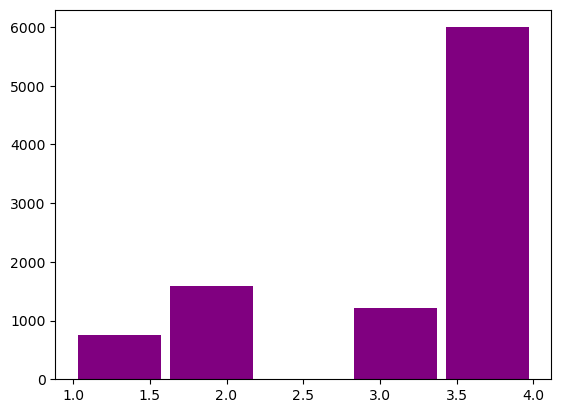

In [6]:
#histogram of target variable.
#df.hist(column = "Target", bins=5, grid=False, rwidth=.9, color='purple')

plt.hist(df["Target"], bins = 5, rwidth=.9, color='purple')

df["Target"].value_counts()

In [28]:
df['=1 if female'].sum()

4937

In [24]:
df['=1 if male'].value_counts()

=1 if male
0    4937
1    4620
Name: count, dtype: int64

In [16]:
#Count number of unique values
print(df['Household level identifier'].nunique())

df.shape

n= 9557/2988

print("observation per household:", n)

#each household has around 3 observations

2988
observation per household: 3.1984605087014724


In [16]:
# Correct label inconsistencies
all_equal = df.groupby("Household level identifier")['Target'].apply(lambda x: x.nunique() == 1)
not_equal = all_equal[all_equal != True]

# Iterate through inconsistent rows
for i in not_equal.index:
    # Check if there is at least one row where "Household level identifier" is i and "=1 if household head" is 1
    matching_rows = df[(df["Household level identifier"] == i) & (df["=1 if household head"] == 1)]

    # Check if there are any matching rows
    if matching_rows.empty:
        # If no such row exists, skip to the next iteration
        continue
    
    # Retrieve the correct "Target" value from the first matching row
    true_target = int(matching_rows["Target"].iloc[0])
    
    # Update the "Target" column for all rows where "=1 if household head" is i with the correct value
    df.loc[df["=1 if household head"] == i, "Target"] = true_target


In [18]:
#Drop squared variables
df = df.drop(df.loc[:, 'escolari squared':'Age squared'].columns, axis=1)

df.head()

KeyError: 'escolari squared'

In [19]:
df.shape

(9557, 134)

In [27]:
#Investigate NA
NAs = pd.DataFrame(df.isna().sum())
NAs.rename(columns = {0:"Total"}, inplace = True)
NAs

NAs.sort_values("Total", ascending = False).head(8)

,Total
Years behind in school,7928
number of tablets household owns,7342
Monthly rent payment,6860
average years of education for adults (18+),5
=1 if brother/sister in law,0
=1 if son/doughter in law,0
=1 if grandson/doughter,0
=1 if mother/father,0


In [37]:
#Years behind schooling: Based on discussion on Kaggle, replace NA with 0 (= not behind in school). 
#NA = person did not yet start schooling 
# This variable is only collected for people between 7 and 19 years of age and it is the difference between the years of education a person should have and the years of education he/she has. 
#It is capped at 5.

df["Years behind in school"].describe()

df.loc[((df["Age in years"] > 19) | (df["Age in years"] < 7)) & (df["Years behind in school"].isnull()), "Years behind in school"] = 0


# Cap the Years behind in school at 5
df.loc[df["Years behind in school"] > 5, "Years behind in school"] = 5


#Fill all other variables with 0
df["Years behind in school"] = df["Years behind in school"].fillna(0)

In [30]:
#Based on discussion of dataset, check if monthly rate payments are indeed

df_subset = df[df['Monthly rent payment'].isna()]

#df[["monthly rent payment", "=1 rented'"'=1 own and fully paid house','=1 other(assigned, borrowed)'
 #'=1 own, paying in installments']]

#null_data = df[df.isnull().any(axis=1)]
#list(df)

df_subset= df_subset[['Monthly rent payment', "=1 rented", "=1 own and fully paid house",'=1 other(assigned, borrowed)', "=1 own, paying in installments"]]

df_subset.head(10)


#Total number of monthly rate payment
df_subset[["=1 own and fully paid house", "=1 own, paying in installments"]].sum()

df_subset.sum()

#Out of 2156 missing values, 1856 are own and fully paid houses, 254 are assigned or borrowed. Therefore, 46 are missing values.
#Result: assign all with 0

Monthly rent payment                 0.0
=1 rented                            0.0
=1 own and fully paid house       5911.0
=1 other(assigned, borrowed)       786.0
=1 own, paying in installments       0.0
dtype: float64

In [31]:
#Replace missing values of monthly rate payment with 0
df['Monthly rent payment'] = df['Monthly rent payment'].fillna(0)

In [12]:
#Number of tablet owns, many missing values. Other column displays binary variables- own ipad (yes/no)
#Assumption: missing values = owe no ipad

df_subset2 = df[df["number of tablets household owns"].isna()]

df_subset2 = pd.DataFrame(df_subset2)

df_subset2 = df_subset2[["number of tablets household owns", "owns a tablet"]]

df_subset2.head(10)

#Calculate sum of "owns a tablet": if sum is zero, we know that all the households own no tablet

df_subset2["owns a tablet"].sum()

#Result: Yes all of the household owe no tablet => replace all values with 0

0

In [32]:
#Replace all NaN in households with 0
df["number of tablets household owns"] = df["number of tablets household owns"].fillna(0)

In [33]:
#Replace average years of education for adults (18+) with 0
df["average years of education for adults (18+)"] = df["average years of education for adults (18+)"].fillna(0)

In [38]:
#Check if all NAs are gone-> Yes
NAs = pd.DataFrame(df.isna().sum())
NAs.rename(columns = {0:"Total"}, inplace = True)
NAs

NAs.sort_values("Total", ascending = False).head(8)


,Total
Id,0
=1 if spouse/partner,0
# of individuals 65+ in the household,0
Number of adults in household,0
Number of children 0 to 19 in household,0
Household level identifier,0
=1 if other non family member,0
=1 if other family member,0


In [39]:
#Identify variables that need to be rounded
types = df.dtypes == float

print(types.to_string())

Id                                                                                  False
Monthly rent payment                                                                 True
=1 Overcrowding by bedrooms                                                         False
number of all rooms in the house                                                    False
=1 Overcrowding by rooms                                                            False
=1 has toilet in the household                                                      False
=1 if the household has refrigerator                                                False
owns a tablet                                                                       False
number of tablets household owns                                                     True
Males younger than 12 years of age                                                  False
Males 12 years of age and older                                                     False
Total male

In [40]:
#Round variables to 2 decimal points (e.g. # persons per room)

df.head(10)

df[["# persons per room", "average years of education for adults (18+)", "Dependency rate", "years of education of male head of household", "years of education of female head of household"]] = df[["# persons per room", "average years of education for adults (18+)", "Dependency rate", "years of education of male head of household", "years of education of female head of household"]].round(2)


df.head(20)

,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,Males younger than 12 years of age,Males 12 years of age and older,Total males in the household,Females younger than 12 years of age,Females 12 years of age and older,Total females in the household,persons younger than 12 years of age,persons 12 years of age and older,Total persons in the household,size of the household,number of persons living in the household,years of schooling,Years behind in school,household size,=1 if predominant material on the outside wall is block or brick,"=1 if predominant material on the outside wall is socket (wood, zinc or absbesto",=1 if predominant material on the outside wall is prefabricated or cement,=1 if predominant material on the outside wall is waste material,=1 if predominant material on the outside wall is wood,=1 if predominant material on the outside wall is zink,=1 if predominant material on the outside wall is natural fibers,=1 if predominant material on the outside wall is other,"=1 if predominant material on the floor is mosaic, ceramic, terrazo",=1 if predominant material on the floor is cement,=1 if predominant material on the floor is other,=1 if predominant material on the floor is natural material,=1 if no floor at the household,=1 if predominant material on the floor is wood,=1 if predominant material on the roof is metal foil or zink,"=1 if predominant material on the roof is fiber cement, mezzanine",=1 if predominant material on the roof is natural fibers,=1 if predominant material on the roof is other,=1 if the house has ceiling,=1 if water provision inside the dwelling,=1 if water provision outside the dwelling,=1 if no water provision,"=1 electricity from CNFL, ICE, ESPH/JASEC",=1 electricity from private plant,=1 no electricity in the dwelling,=1 electricity from cooperative,=1 no toilet in the dwelling,=1 toilet connected to sewer or cesspool,=1 toilet connected to septic tank,=1 toilet connected to black hole or letrine,=1 toilet connected to other system,=1 no main source of energy used for cooking (no kitchen),=1 main source of energy used for cooking electricity,=1 main source of energy used for cooking gas,=1 main source of energy used for cooking wood charcoal,=1 if rubbish disposal mainly by tanker truck,=1 if rubbish disposal mainly by botan hollow or buried,=1 if rubbish disposal mainly by burning,=1 if rubbish disposal mainly by throwing in an unoccupied space,"=1 if rubbish disposal mainly by throwing in river, creek or sea",=1 if rubbish disposal mainly other,=1 if walls are bad,=1 if walls are regular,=1 if walls are good,=1 if roof are bad,=1 if roof are regular,=1 if roof are good,=1 if floor are bad,=1 if floor are regular,=1 if floor are good,=1 if disable person,=1 if male,=1 if female,=1 if less than 10 years old,=1 if free or coupled union,=1 if married,=1 if divorced,=1 if separated,=1 if widow/er,=1 if single,=1 if household head,=1 if spouse/partner,=1 if son/doughter,=1 if stepson/doughter,=1 if son/doughter in law,=1 if grandson/doughter,=1 if mother/father,=1 if father/mother in law,=1 if brother/sister,=1 if brother/sister in law,=1 if other family member,=1 if other non family member,Household level identifier,Number of children 0 to 19 in household,Number of adults in household,# of individuals 65+ in the household,# of total individuals in the household,Dependency rate,years of education of male head of household,years of education of female head of household,average years of education for adults (18+),=1 no level of education,=1 incomplete primary,=1 complete primary,=1 incomplete academic secondary level,=1 complete academic secondary level,=1 incomplete technical secondary level,=1 complete technical secondary level,=1 undergraduate and higher education,=1 postgraduate higher education,number of bedrooms,# person

In [27]:
#Distribution of fairness attributes 
#region 
test = df[["=1 region Central","=1 region Chorotega", "=1 region Pacifico central", "=1 region Brunca", "=1 region Huetar Atlantica", "=1 region Huetar Norte", "Target"]].sum() 

test = pd.DataFrame(test)

test.rename(columns = {0:"Total"}, inplace = True)

print(test)

temp = df.loc[(df["=1 region Central"]== 1) & (df["Target"] == 4)]

print(temp)


                            Total
=1 region Central            5616
=1 region Chorotega           886
=1 region Pacifico central    596
=1 region Brunca              791
=1 region Huetar Atlantica    897
=1 region Huetar Norte        771
Target                      31560
                Id  Monthly rent payment  =1 Overcrowding by bedrooms  \
0     ID_279628684              190000.0                            0   
1     ID_f29eb3ddd              135000.0                            0   
2     ID_68de51c94                   NaN                            0   
3     ID_d671db89c              180000.0                            0   
4     ID_d56d6f5f5              180000.0                            0   
...            ...                   ...                          ...   
5600  ID_34d29f00d                   NaN                            0   
5601  ID_bc734f4cc                   NaN                            0   
5602  ID_c4ad6399f                   NaN                            0  

In [42]:
#Create new datatset

#df = df.to_csv('train_classification_v2_updated.csv', index = True)